## checking model form huggingface 


In [1]:
import os
os.environ['TORCH_USE_CUDA_DSA'] = '1'
os.environ["CUDA_LAUNCH_BLOCKING"] = '1'
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

from mycelia.shared.config import MinerConfig
from mycelia.shared.dataloader import get_dataloader
from __future__ import annotations

from mycelia.shared.expert_manager import is_expert_param
from mycelia.shared.modeling.modeling_mycelia import get_layer_expert_id

/home/isabella/crucible/subnet-MoE/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version 2.8.0 available.


In [ ]:
model_name = "Qwen/Qwen3-Next-80B-A3B-Thinking"
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Load model sharded across all GPUs
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float32,
    device_map='cpu',
)
model.config.output_router_logits = True
model.eval()

Loading checkpoint shards: 100%|██████████| 41/41 [01:36<00:00,  2.35s/it]


Qwen3NextForCausalLM(
  (model): Qwen3NextModel(
    (embed_tokens): Embedding(151936, 2048)
    (layers): ModuleList(
      (0-2): 3 x Qwen3NextDecoderLayer(
        (linear_attn): Qwen3NextGatedDeltaNet(
          (act): SiLUActivation()
          (conv1d): Conv1d(8192, 8192, kernel_size=(4,), stride=(1,), padding=(3,), groups=8192, bias=False)
          (in_proj_qkvz): Linear(in_features=2048, out_features=12288, bias=False)
          (in_proj_ba): Linear(in_features=2048, out_features=64, bias=False)
          (norm): Qwen3NextRMSNormGated()
          (out_proj): Linear(in_features=4096, out_features=2048, bias=False)
        )
        (mlp): Qwen3NextSparseMoeBlock(
          (gate): Linear(in_features=2048, out_features=512, bias=False)
          (experts): ModuleList(
            (0-511): 512 x Qwen3NextMLP(
              (gate_proj): Linear(in_features=2048, out_features=512, bias=False)
              (up_proj): Linear(in_features=2048, out_features=512, bias=False)
           

In [ ]:
shared_param = 0
expert_param = 0
for n, p in model.named_parameters():
    if is_expert_param(n):
        layer_id, expert_id = get_layer_expert_id(n)
        if expert_id == 1:  
            expert_param += p.numel()
    else:
        shared_param += p.numel()

active_param = shared_param + expert_param * 43

print('shared', shared_param / 1e9, '\nexpert_param', expert_param / 1e9, '\nactive param', expert_param / 1e9 * 43, '\ntotal_param', active_param / 1e9)

shared 2.21388672 
expert_param 0.150994944 
active param 6.492782591999999 
total_param 8.706669312


In [ ]:
rank = 0
config = MinerConfig()
config.task.data.batch_size = 1
config.task.data.sequence_length = 100
config.task.data.dataset_name = "open-r1/OpenR1-Math-220k"
config.task.data.data_dir = None
train_dataloader = get_dataloader(config, rank=rank, world_size=config.task.data.world_size, tokenizer=tokenizer, format_fn = format_example_r1)
iter_dataloader = iter(train_dataloader)

2025-11-17 20:53:12 [warning  ] Cannot find the wallet key by name coldkey name: template_coldkey_name, hotkey name: template_hotkey_name, please make sure it has been set correctly if you are reloading from a config.json or use --hotkey_name & --coldkey_name when you are creating a config file from a template. [mycelia.shared.config] error=Generic error: Failed to get hotkey: FileNotFound("Keyfile at: /home/isabella/.bittensor/wallets/template_coldkey_name/hotkeys/template_hotkey_name does not exist.")


Too many dataloader workers: 4 (max is dataset.n_shards=1). Stopping 3 dataloader workers.


Too many dataloader workers: 4 (max is dataset.n_shards=1). Stopping 3 dataloader workers.
keepalive ping failed
TimeoutError: timed out while closing connection

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/isabella/crucible/subnet-MoE/.venv/lib/python3.10/site-packages/websockets/sync/connection.py", line 777, in keepalive
    with self.send_context():
  File "/usr/lib/python3.10/contextlib.py", line 142, in __exit__
    next(self.gen)
  File "/home/isabella/crucible/subnet-MoE/.venv/lib/python3.10/site-packages/websockets/sync/connection.py", line 1012, in send_context
    raise self.protocol.close_exc from original_exc
websockets.exceptions.ConnectionClosedError: sent 1011 (internal error) keepalive ping timeout; no close frame received


In [ ]:
model.eval()
outputs = []
for i in range(20):
    tokens = next(iter_dataloader)
    for k, v in tokens.items():
        tokens[k] = v[0]
    del tokens['labels']
    with torch.no_grad():
        tokens.to(model.device)
        output = model(**tokens)
    outputs.append(output)

In [ ]:
from itertools import chain
from collections import Counter
import torch.nn.functional as F

def route_tokens_to_experts(router_logits):
    routing_weights = F.softmax(router_logits, dim=-1, dtype=torch.float)
    routing_weights, selected_experts = torch.topk(routing_weights, 10, dim=-1)
    if True:
        routing_weights /= routing_weights.sum(dim=-1, keepdim=True)
    routing_weights = routing_weights.to(router_logits.dtype)
    return selected_experts, routing_weights

counts_per_layer = {}
for layer_id in range(len(outputs[0].router_logits)): 
    all_selected_experts = []
    for output in outputs: 
        selected_experts, routing_weight = route_tokens_to_experts(output.router_logits[layer_id])
        all_selected_experts.append(selected_experts)
    flat = list(chain.from_iterable(torch.concat(all_selected_experts).tolist()))
    counts_per_layer[layer_id] = Counter(flat)

tensor(43.2708)

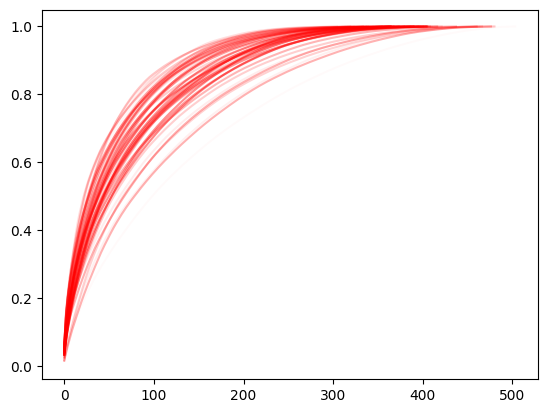

In [ ]:
import matplotlib.pyplot as plt 

layer_id = 30

idx_sum = 0 
for layer_id in range(48):
    count = torch.tensor(list(counts_per_layer[layer_id].values()))
    count_norm = (count / count.sum()).sort(descending = True)[0]

    cumsum = torch.cumsum(count_norm, dim=0)
    threshold = 0.5
    idx = torch.searchsorted(cumsum, threshold)
    plt.plot(cumsum, color = 'red', alpha = layer_id / 100)
    idx_sum += idx

idx_sum / 48

In [ ]:
counts_per_layer

NameError: name 'counts_per_layer' is not defined